# Import Libraries (Required)

Import our essential Libraries


In [34]:
import os
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Average
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.vgg19 import VGG19

# Fetch Dataset (Required)

Some shell script to check if the data already exists, if not clone it from git.



In [22]:
%%shell

if [ ! -d '/tmp/pneumoniaDataset' ]; then 
  mkdir '/tmp/pneumoniaDataset'
fi

if [ ! -d '/tmp/pneumoniaDataset/.git' ]; then 
  git clone "https://github.com/Amzo/xray_images" '/tmp/pneumoniaDataset/'
fi

In [23]:
dataIsFetched = True

# Datasetup (Required)

Load our data and generate additional augmented data due to the nature of the small data set. Since the data is already structured into train, test and validate folders, we don't need to split the data here.


In [17]:
def getData(trainDir, testDir, valDir):
        class_names = os.listdir(trainDir)
        class_types = len(os.listdir(trainDir))

        print('Number of classes for Classification: ',class_types)
        print(f'The class names are {class_names[0]} and {class_names[1]}')
        print('--> Count of Train Images <--')

        for i in class_names:
                print(i + ':' + str(len(os.listdir(trainDir + "/" +i))))
        print('--> Count of Test Images <--')

        for i in class_names:
                print(i + ':' + str(len(os.listdir(testDir + '/' +i))))

        print('--> Count of Validation Images <---')
        for i in class_names:
                print(i + ':' + str(len(os.listdir(valDir + '/' +i))))

        train_datagen = ImageDataGenerator(rescale=1./255.0,
                rotation_range=6,
                zoom_range=0.1,
                horizontal_flip = True,
                vertical_flip = True
                )

        test_datagen = ImageDataGenerator(rescale=1./255.0)

        xTrainGen = train_datagen.flow_from_directory(
                trainDir,
                target_size=(224,224),
                shuffle=True,
                batch_size=24,
                class_mode='categorical'
        )

        xTestGen = test_datagen.flow_from_directory(
                testDir,
                target_size=(224,224),
                batch_size=16,
                shuffle=True,
                class_mode='categorical'
        )

        xValGen = train_datagen.flow_from_directory(
                valDir,
                target_size=(224,224),
                batch_size=32,
                class_mode='categorical'
        )

        return xTrainGen, xTestGen, xValGen

In [25]:
try:
  dataIsFetched
except NameError:
  print("Data has not been fetched, run the fetch data cells")
else:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  assert len(physical_devices) > 0, "Not enough GPU hardware devices available"


  inputTrain = '/tmp/pneumoniaDataset/train'
  inputTest = '/tmp/pneumoniaDataset/test'
  inputValidate = '/tmp/pneumoniaDataset/val'

  imageSize = (224,224,3)

  xTrain, xTest, xVal = getData(inputTrain, inputTest, inputValidate)

  dataIsSetup = True


Number of classes for Classification:  2
The class names are PNEUMONIA and NORMAL
--> Count of Train Images <--
PNEUMONIA:3851
NORMAL:1305
--> Count of Test Images <--
PNEUMONIA:390
NORMAL:234
--> Count of Validation Images <---
PNEUMONIA:32
NORMAL:44
Found 5156 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


# Data Visualisation

In [148]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [151]:
try:
  dataIsSetup
except NameError:
  print("please execute the dataSetup section before training")
else:
  augmentedImages = [xTrain[0][0][0] for i in range(5)]

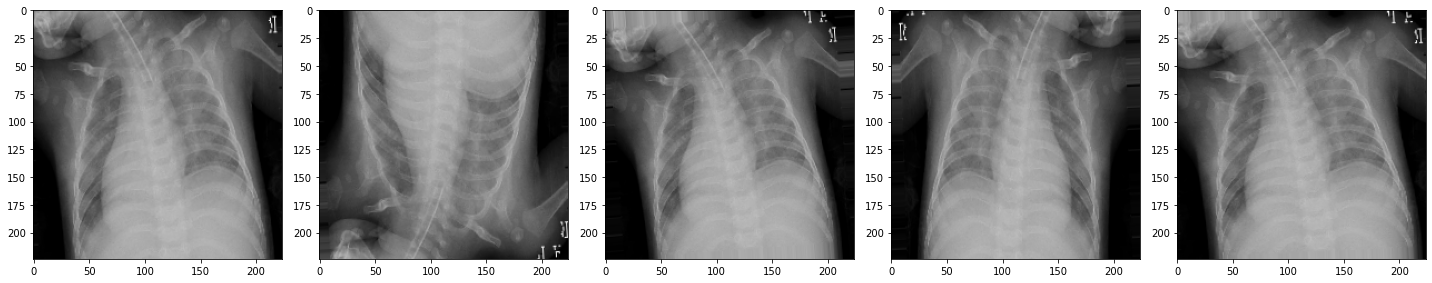

In [152]:
plotImages(augmentedImages)

# Model Setup

In [12]:
def myModel():
  print("Defaulting to basic CNN")
  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(2,activation='softmax'))

  model.compile(optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"])
  
  return model

Create an Exception model. This model needs a lot of resources and will not run on my system.

Using RMSprop optimiser and setting a learning rate to 0.0001. As our classification is either true or false, E.G they have something or they don't, use binary_crossentropy.


In [8]:
def modelBuild(inputShape, modelType):
  model = Sequential()
  if (modelType == "xception"):
    print("Setting up xception model")
    xception = Xception(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(xception)

  elif (modelType == "resnet"):
    print("Setting up resnet50 model")
    resnet = ResNet50V2(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(resnet)

  elif (modelType == "vgg19"):
    print("Setting up vgg19 model")
    vgg = VGG19(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(vgg)
  elif (modelType == "inception"):
    print("Setting up inception model")
    inception = InceptionV3(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(inception)

  model.add(Flatten())
  model.add(Dense(512, activation="relu"))
  model.add(Dense(2,activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

  return model


In [13]:
xception = modelBuild(imageSize, 'xception')
vgg19 = modelBuild(imageSize, 'vgg19')
resnet = modelBuild(imageSize, 'resnet')
inception = modelBuild(imageSize, 'inception')
myCNN = myModel()

modelsSetup = True

Setting up xception model
Setting up vgg19 model
Setting up resnet50 model
Setting up inception model
Defaulting to basic CNN


# Train Models

In [10]:
def modelTrain(model, xTrain, xVal, batchSize):
  history = model.fit(xTrain,
    epochs=10,
    validation_data=xVal,
    verbose=1,
    batch_size=batchSize
  )

  return history, model


I could create a function to check if the models have been setup, but you can never be certain if a cell has been executed or not, so rely on global variables being true or false. This means duplication, but it's should reduce errors.

In [1]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  inceptionHistoy, trainedInception = modelTrain(inception, xTrain, xVal, 32)


please execute the model Setup section before training


In [51]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  vggHistory, trainedVGG = modelTrain(vgg19, xTrain, xVal, 32)


Epoch 1/10
215/215 [==============================] - 132s 604ms/step - loss: 0.5927 - accuracy: 0.7606 - val_loss: 0.3462 - val_accuracy: 0.8947
Epoch 2/10
215/215 [==============================] - 129s 599ms/step - loss: 0.2285 - accuracy: 0.9082 - val_loss: 0.2964 - val_accuracy: 0.9079
Epoch 3/10
215/215 [==============================] - 129s 597ms/step - loss: 0.1701 - accuracy: 0.9341 - val_loss: 0.5444 - val_accuracy: 0.7237
Epoch 4/10
215/215 [==============================] - 128s 596ms/step - loss: 0.1631 - accuracy: 0.9437 - val_loss: 0.3596 - val_accuracy: 0.8553
Epoch 5/10
215/215 [==============================] - 129s 597ms/step - loss: 0.1406 - accuracy: 0.9507 - val_loss: 0.5724 - val_accuracy: 0.8289
Epoch 6/10
215/215 [==============================] - 128s 596ms/step - loss: 0.1417 - accuracy: 0.9544 - val_loss: 0.1718 - val_accuracy: 0.9474
Epoch 7/10
215/215 [==============================] - 128s 595ms/step - loss: 0.1379 - accuracy: 0.9488 - val_loss: 0.2204 -

In [53]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  resnetHistory, trainedResnet = modelTrain(resnet, xTrain, xVal, 32)


Epoch 1/10
215/215 [==============================] - 131s 557ms/step - loss: 0.7537 - accuracy: 0.8930 - val_loss: 5.0193 - val_accuracy: 0.8026
Epoch 2/10
215/215 [==============================] - 115s 535ms/step - loss: 0.1189 - accuracy: 0.9628 - val_loss: 53.9550 - val_accuracy: 0.7368
Epoch 3/10
215/215 [==============================] - 114s 531ms/step - loss: 0.1178 - accuracy: 0.9736 - val_loss: 68.1012 - val_accuracy: 0.5658
Epoch 4/10
215/215 [==============================] - 114s 531ms/step - loss: 0.2325 - accuracy: 0.9707 - val_loss: 97.8651 - val_accuracy: 0.5921
Epoch 5/10
215/215 [==============================] - 115s 532ms/step - loss: 0.0881 - accuracy: 0.9757 - val_loss: 13.5714 - val_accuracy: 0.8684
Epoch 6/10
215/215 [==============================] - 115s 533ms/step - loss: 0.1322 - accuracy: 0.9780 - val_loss: 60.8814 - val_accuracy: 0.5921
Epoch 7/10
215/215 [==============================] - 114s 531ms/step - loss: 0.0829 - accuracy: 0.9755 - val_loss: 0.6

In [ ]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  ourCNNHistory, trainedCNN = modelTrain(myCNN, xTrain, xVal, 32)

In [57]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  xceptionHistory, trainedXception = modelTrain(xception, xTrain, xVal, 32)

Epoch 1/10
215/215 [==============================] - 149s 648ms/step - loss: 0.3909 - accuracy: 0.9040 - val_loss: 3.1307 - val_accuracy: 0.7500
Epoch 2/10
215/215 [==============================] - 134s 621ms/step - loss: 0.1445 - accuracy: 0.9651 - val_loss: 7.5546 - val_accuracy: 0.5921
Epoch 3/10
215/215 [==============================] - 134s 621ms/step - loss: 0.0850 - accuracy: 0.9753 - val_loss: 0.9293 - val_accuracy: 0.8816
Epoch 4/10
215/215 [==============================] - 134s 621ms/step - loss: 0.0646 - accuracy: 0.9817 - val_loss: 0.9907 - val_accuracy: 0.9079
Epoch 5/10
215/215 [==============================] - 134s 621ms/step - loss: 0.0709 - accuracy: 0.9857 - val_loss: 0.1090 - val_accuracy: 0.9737
Epoch 6/10
215/215 [==============================] - 134s 621ms/step - loss: 0.0840 - accuracy: 0.9791 - val_loss: 1.2075 - val_accuracy: 0.8684
Epoch 7/10
215/215 [==============================] - 134s 620ms/step - loss: 0.0628 - accuracy: 0.9833 - val_loss: 0.5354 -

# Save Trained Models (Optional)

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
try:
  trainedInception
except NameError:
  print("Have you trained the Inception model to save?")
else:
  trainedInception.save('/content/gdrive/MyDrive/Inception')

  with open('/content/gdrive/MyDrive/inceptionHistory.pickle', 'wb') as outFile:
    pickle.dump(inceptionHistoy.history, outFile)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Inception/assets


In [52]:
try:
  trainedVGG
except NameError:
  print("Have you trained the VGG model to save?")
else:
  trainedVGG.save('/content/gdrive/MyDrive/VGG')

  with open('/content/gdrive/MyDrive/vggHistory.pickle', 'wb') as outFile:
    pickle.dump(vggHistory.history, outFile)
  

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/VGG/assets


In [54]:
try:
  trainedResnet
except NameError:
  print("Have you trained the resnet model to save?")
else:
  trainedResnet.save('/content/gdrive/MyDrive/Resnet')
  
  with open('/content/gdrive/MyDrive/resnetHistory.pickle', 'wb') as outFile:
    pickle.dump(resnetHistory.history, outFile)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Resnet/assets


In [56]:
try:
  trainedCNN
except NameError:
  print("Have you trained myCNN model to save?")
else:
  trainedCNN.save('/content/gdrive/MyDrive/myCNN')

  with open('/content/gdrive/MyDrive/ourCNNHistory.pickle', 'wb') as outFile:
    pickle.dump(ourCNNHistory.history, outFile)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/myCNN/assets


In [58]:
try:
  trainedXception
except NameError:
  print("Have you trained the Xception model to save?")
else:
  trainedXception.save('/content/gdrive/MyDrive/xception')

  with open('/content/gdrive/MyDrive/xceptionHistory.pickle', 'wb') as outFile:
    pickle.dump(xceptionHistory.history, outFile)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/xception/assets


# fetch Trained Models

This shell script will fetch all the models and history from my one drive so that it can be loaded. Will save an hour or two over waiting for training to finish.

Shell variables don't appear to be reusable from other cells, so perform all the shell script in one cell.

In [1]:
%%shell
function extractModel() {
  outDIR="/tmp/trainedModels/"

  # check if the directory exits, if not create it
  if [ ! -d $outDIR ]; then 
    mkdir -p $outDIR; 
  fi

  # extract the model
  echo "extracting ${1} to ${outDIR}"
  unzip -q -o -d $outDIR $1 
}

function getFile() {
  googleURL="https://docs.google.com/uc?export=download"
  echo "fetching file: ${2}"
  wgetCMD="wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate"
  fileID="$1"
  outFILE="/tmp/$2"

  if [ -f $outFILE ]; then
    rm -f $outFILE
  fi
  
  wget  -q --load-cookies /tmp/cookies.txt "$googleURL&confirm=$($wgetCMD "$googleURL&id=$fileID" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$fileID" -O $outFILE
  rm -rf /tmp/cookies.txt
  
  if [ ${outFILE##*.} == "zip" ]; then
    extractModel $outFILE
  fi
}

# inception model
getFile "185GypHJV8sTcL3siYXinoClbXP0OEYr1" "trainedInception.zip"

# inception history
getFile "1kqAMFgH5H-_k1cKYuuatSuZiG-xtajh_" "inceptionHistory.pickle"

# vgg model
getFile "163-EY3aU6_7OP0Ds2Gq4bIu9r84f4txJ" "trainedVgg.zip"

# vgg history
getFile "1-0H4ZjHitt8FMC1ZjZun1wlXrFMjFE5N" "vggHistory.pickle"

# resnet model
getFile "1E4pHn5-4-9VXDIdlk9qFZya1TjL_u3P-" "trainedResnet.zip"

# resnet history
getFile "1-0nN6H7lMCNPD4tlS_CXD1JMEXPcFnc9" "resnetHistory.pickle"

# myCNN model
getFile "16Ko5GLm4D3jz6F7s85FkoqCDrI4vUeiV" "trainedCNN.zip"

# myCNN history
getFile "1-BFAv4_m3fwlYLgWCWbziSQPplKlGfvQ" "ourCNNHistory.pickle"

# xception model
getFile "1qqRKAyN5lowZ3VE8cQZWBU54eP-QA9q-" "trainedXception.zip"

# xception history
getFile "1-HHmEafOoAMlYXngAS8sjagA-Evlc3n9" "xceptionHistory.pickle"

fetching file: trainedInception.zip
extracting /tmp/trainedInception.zip to /tmp/trainedModels/
fetching file: inceptionHistory.pickle
fetching file: trainedVgg.zip
extracting /tmp/trainedVgg.zip to /tmp/trainedModels/
fetching file: vggHistory.pickle
fetching file: trainedResnet.zip
extracting /tmp/trainedResnet.zip to /tmp/trainedModels/
fetching file: resnetHistory.pickle
fetching file: trainedCNN.zip
extracting /tmp/trainedCNN.zip to /tmp/trainedModels/
fetching file: ourCNNHistory.pickle
fetching file: trainedXception.zip
extracting /tmp/trainedXception.zip to /tmp/trainedModels/
fetching file: xceptionHistory.pickle


In [2]:
modelsAreFetched = True

# Load Models

In [3]:
historyList = ["inceptionHistory", "vggHistory", "resnetHistory", "ourCNNHistory", "xceptionHistory"]

In [4]:
modelList = ["Inception", "Resnet", "VGG", "myCNN", "xception"]

In [7]:
try:
  modelsAreFetched
except NameError:
  print("You need to fetch the models to load them")
else:
  for pickleFile in historyList:
    with open('/tmp/' + pickleFile + '.pickle', 'rb') as input:
      if (pickleFile == "inceptionHistory"):
        print("Loading history file: " + pickleFile)
        inceptionHistory = pickle.load(input)
      elif (pickleFile == "resnetHistory"):
        print("Loading history file: " + pickleFile)
        resnetHistory = pickle.load(input)
      elif (pickleFile == "vggHistory"):
        print("Loading history file: " + pickleFile)
        vggHistory = pickle.load(input)
      elif (pickleFile == "ourCNNHistory"):
        print("Loading history file: " + pickleFile)
        myCNNHistory = pickle.load(input)
      elif (pickleFile == "xceptionHistory"):
        print("Loading history file: " + pickleFile)
        xceptionHistory = pickle.load(input)

      historyIsFetched = True

Loading history file: inceptionHistory
Loading history file: vggHistory
Loading history file: resnetHistory
Loading history file: ourCNNHistory
Loading history file: xceptionHistory


In [8]:
try:
  modelsAreFetched
except NameError:
  print("You have to fetch the models before you can load them")
else:
  for trainedModel in modelList:
    print("Loading model " + trainedModel)
    if (trainedModel == "Inception"):
      trainedInception = tf.keras.models.load_model('/tmp/trainedModels/' + trainedModel)
    elif (trainedModel == "Resnet"):
      trainedResnet = tf.keras.models.load_model('/tmp/trainedModels/' + trainedModel)
    elif (trainedModel == "VGG"):
      trainedVGG = tf.keras.models.load_model('/tmp/trainedModels/' + trainedModel)
    elif (trainedModel == "myCNN"):
      trainedCNN = tf.keras.models.load_model('/tmp/trainedModels/' + trainedModel)
    elif (trainedModel == "xception"):
      trainedXception = tf.keras.models.load_model('/tmp/trainedModels/' + trainedModel)

Loading model Inception
Loading model Resnet
Loading model VGG
Loading model myCNN
Loading model xception


# Test Models

In [14]:
def evaluateModel(model):
  ev = model.evaluate(xTest)
  print("\n%s: %.f%%" % (model.metrics_names[1], ev[1]*100))

In [26]:
try:
  dataIsSetup
except NameError:
  print("Please run datasetup cells first")
else:
  for trainedModel in modelList:
      print("Running " + trainedModel + " against test set")
      if (trainedModel == "Inception"):
        evaluateModel(trainedInception)
      elif (trainedModel == "Resnet"):
        evaluateModel(trainedResnet)
      elif (trainedModel == "VGG"):
        evaluateModel(trainedVGG)
      elif (trainedModel == "myCNN"):
        evaluateModel(trainedCNN)
      elif (trainedModel == "xception"):
        evaluateModel(trainedXception)

Running Inception against test set
39/39 [==============================] - 40s 154ms/step - loss: 0.5461 - accuracy: 0.9103

accuracy: 91%
Running Resnet against test set
39/39 [==============================] - 8s 154ms/step - loss: 3.5268 - accuracy: 0.9151

accuracy: 92%
Running VGG against test set
39/39 [==============================] - 10s 160ms/step - loss: 0.3756 - accuracy: 0.9022

accuracy: 90%
Running myCNN against test set
39/39 [==============================] - 6s 144ms/step - loss: 0.8688 - accuracy: 0.7308

accuracy: 73%
Running xception against test set
39/39 [==============================] - 8s 155ms/step - loss: 4.1356 - accuracy: 0.9183

accuracy: 92%


# model Visualisation

In [18]:
def visualiseHistory(historyFile):
  try:
    plt.plot(historyFile.history['accuracy'], label='accuracy')
    plt.plot(historyFile.history['val_accuracy'], label = 'val_accuracy')
  except AttributeError:
    plt.plot(historyFile['accuracy'], label='accuracy')
    plt.plot(historyFile['val_accuracy'], label = 'val_accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

  test_loss, test_acc = trainedCNN.evaluate(xTest, verbose=2)

In [19]:
def visualiseLoss(historyFile):
  # summarize history for loss
  try:
    plt.plot(historyFile.history['loss'])
    plt.plot(historyFile.history['val_loss'])
  except AttributeError:
    plt.plot(historyFile['loss'])
    plt.plot(historyFile['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

39/39 - 5s - loss: 0.7656 - accuracy: 0.7628


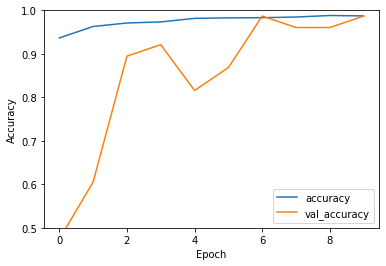

In [20]:
visualiseHistory(inceptionHistory)

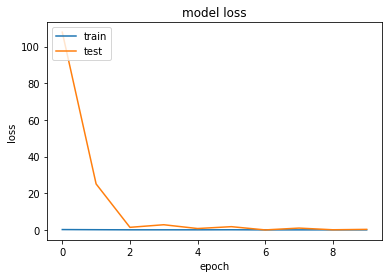

In [21]:
visualiseLoss(inceptionHistory)

39/39 - 5s - loss: 0.7656 - accuracy: 0.7628


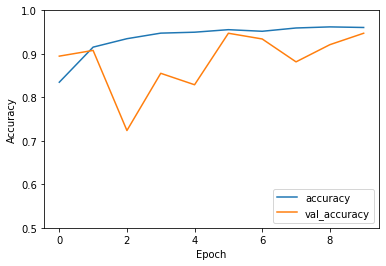

In [22]:
visualiseHistory(vggHistory)

In [ ]:
visualiseLoss(vggHistory)

In [ ]:
visualiseHistory(myCNNHistory)

In [ ]:
visualiseLoss(myCNNHistory)

In [ ]:
visualiseHistory(resnetHistory)

In [ ]:
visualiseLoss(resnetHistory)

In [ ]:
visualiseHistory(xceptionHistory)

In [ ]:
visualiseLoss(xceptionHistory)

# Ensembling

In [28]:
def getVoting():
  models = list()
  models.append(trainedInception)
  models.append(trainedVGG)
  models.append(trainedResnet)
  models.append(trainedCNN)
  models.append(trainedXception)

  return models

In [29]:
combinedModel = getVoting()

In [32]:
modelInput = Input(shape=(224, 224, 3))
modelOutputs = [model(modelInput) for model in combinedModel]
ensembleOutput = Average()(modelOutputs)

In [35]:
ensembleModel = Model(inputs=modelInput, outputs=ensembleOutput, name='ensemble')

In [36]:
ensembleModel.compile(optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [37]:
print("Running ensembled model against test set")
evaluateModel(ensembleModel)

Running ensembled model against test set
39/39 [==============================] - 14s 233ms/step - loss: 0.2965 - accuracy: 0.9230

accuracy: 93%
